# Remote access and plotting posterior footprint probabilities

This notebook shows an example of how to access remotely hosted DGF data and generate a portion of **Fig. 1b** from Vierstra *et al.* 2020.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
import pysam

from genome_tools import genomic_interval
from genome_tools.plotting import gencode_annotation_track

In [2]:
def unpack(s):
    """Converts a 1-based UCSC coordinate string 
    into a a genomic_interval object"""
    
    tmp = s.replace(",", "")
    (chrom, pos_str) = tmp.split(":")
    start, end = pos_str.split("-")
    return genomic_interval(chrom, int(start)-1, int(end))

class tabix_reader(object):
    def __init__(self, fname, interval):
        self.tabix_handle=pysam.TabixFile(fname)
        self.iter = self.tabix_handle.fetch(interval.chrom, interval.start, interval.end)
    def read(self, n=0):
        try:
            return next(self.iter) + '\n'
        except StopIteration:
            return ''
    def __iter__(self):
        return self
    def __next__(self):
        return self.read()

def tabix_query(filename, interval, fill_val=np.nan):
    """Call tabix and generate an array of strings for each line it returns.
       Posterior matrix removes positions where no sample has posterior value
       >0.8 to save space, so the function adds these positions back and fills them
       with a user-defined fill value
    """
    ret=pd.read_csv(
        tabix_reader(filename, interval), 
        delimiter="\t", header=None, 
        index_col=1).drop([0, 2], axis=1)
    
    ret.index.name="pos"
    ret.columns=np.arange(ret.shape[1])
    
    pos_index=pd.Index(np.arange(interval.start, interval.end))
    
    na_pos=pos_index[~pos_index.isin(ret.index)]
    na_df=pd.DataFrame(np.full([na_pos.shape[0], ret.shape[1]], fill_val), index=na_pos)
    
    return pd.concat([ret, na_df]).sort_index().T

### Read in sample metadata

Read the sample metadata into a dataframe from Supplementary Table 1.

In [3]:
sample_info_file="https://resources.altius.org/~jvierstra/projects/footprinting.2020/Supplementary_Table_1.xlsx"
samples=pd.read_excel(sample_info_file, skiprows=16, index_col=0)
samples.head()

,Taxonomy_class,Taxonomy_system,Description,Individual ID,SPOT,Total_reads,Unique_reads,DCC_experiment_id,DCC_library_id,DCC_biosample_id,DCC_file_id_FDR_1%
Identifier,,,,,,,,,,,
AG10803-DS12374,Primary,Connective,Abdominal skin Fibroblast,Z68,0.6904,369891377,220628368,ENCSR000EMB,ENCLB410ZZZ,ENCBS287ITL,ENCFF989WCF
AoAF-DS13513,Primary,Connective,Aortic Adventitial Fibroblasts,Z94,0.6395,393665970,317762220,ENCSR000EMC,ENCLB412ZZZ,ENCBS408ZNY,ENCFF587TUM
CD19+-DS17186,Primary,Hematopoietic,CD19+ B cells,Z8,0.5056,601010994,488593380,ENCSR381PXW,ENCLB800FZO,ENCBS469TSJ,ENCFF976ZIX
CD20+-DS18208,Primary,Hematopoietic,B cells,Z144,0.5570,300895833,229005077,ENCSR000EMJ,ENCLB425ZZZ,ENCBS483ENC,ENCFF197KBO
GM06990-DS7748,Lines,Hematopoietic,Lymphoblastoid,Z73,0.6547,238189351,142211228,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF825VXW


### Define region to plot

The code below opens up the remotely hosted TABIX file and pulls the data for a specified region.

If you get an ```OSError: could not open index for...``` try deleting the ```.tbi``` file in the current directory. ```pysam``` seems to have a bug in which it cannot find a previously downloaded index.

See https://github.com/pysam-developers/pysam/pull/941 for a suggested bugfix.

In [4]:
interval = unpack("chr19:45,001,882-45,002,279")
# Alternative:
# interval = genomic_interval("chr19", 45001881, 45002279)

# Posterior footprint probability file
posterior_file_url = "https://resources.altius.org/~jvierstra/projects/footprinting.2020/posteriors/"
posterior_file_url += "posteriors.per-nt.bed.gz"

# Read the remotely hosted TABIX-file into a pandas DataFrame class
posteriors=tabix_query(posterior_file_url, interval, fill_val=0)
posteriors.set_index([samples.index, samples["Taxonomy_system"]], inplace=True)
posteriors.columns.name=interval.chrom

posteriors.head()

,chr19,45001881,45001882,45001883,45001884,45001885,45001886,45001887,45001888,45001889,45001890,...,45002269,45002270,45002271,45002272,45002273,45002274,45002275,45002276,45002277,45002278
Identifier,Taxonomy_system,,,,,,,,,,,,,,,,,,,,,
AG10803-DS12374,Connective,0.000000e+00,0.0,0.0,0.0,0.0,7.638446e-07,2.667737e-02,4.164443e-08,1.065814e-14,7.105427e-15,...,2.027643e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AoAF-DS13513,Connective,1.585874e-08,0.0,0.0,0.0,0.0,1.064823e-08,2.448578e-07,1.903719e-08,0.000000e+00,0.000000e+00,...,6.821210e-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD19+-DS17186,Hematopoietic,7.332801e-12,0.0,0.0,0.0,0.0,0.000000e+00,5.897505e-13,0.000000e+00,0.000000e+00,0.000000e+00,...,6.397835e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD20+-DS18208,Hematopoietic,1.186453e-08,0.0,0.0,0.0,0.0,2.842171e-14,4.969465e-10,8.171241e-13,0.000000e+00,0.000000e+00,...,4.286500e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GM06990-DS7748,Hematopoietic,2.450270e-05,0.0,0.0,0.0,0.0,6.063725e-07,2.277550e-05,5.864173e-07,0.000000e+00,0.000000e+00,...,1.101544e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plot gene annotations and heatmap

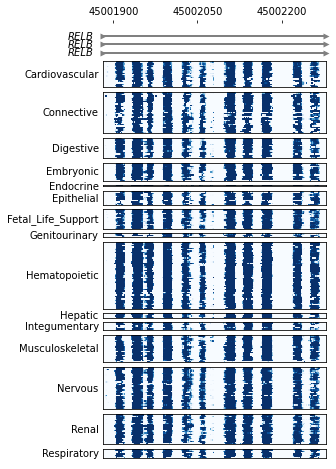

In [6]:
# We are grouping by biosample taxonomy
# level=1 is second level of multi-index
group_sizes=posteriors.groupby(level=1).size()
num_groups=group_sizes.shape[0]

# Code to draw figure
fig=plt.figure()
gs=gridspec.GridSpec(num_groups+1, 1, height_ratios=[0.1] + list(group_sizes/np.sum(group_sizes)))

# Plot gene track

# Gencode annotation
gencode_file_url = "https://resources.altius.org/~jvierstra/projects/footprinting.2020/annotations/"
gencode_file_url += "gencode.v25.chr_patch_hapl_scaff.basic.annotation.gff3.gz"

ax=fig.add_subplot(gs[0,:])
trk_genes = gencode_annotation_track(interval)
trk_genes.load_data(gencode_file_url)
trk_genes.render(ax)

ax.xaxis.set_visible(True)
ax.xaxis.set_ticks_position('top')

# 
row=1
for group, df in posteriors.groupby(level=1):
    ax=fig.add_subplot(gs[row,:])
    ax.pcolormesh(1-np.exp(-df), cmap="Blues")
    ax.xaxis.set_visible(False)
    
    ax.yaxis.set_ticks([])
    ax.set_ylabel(group, rotation=0, ha='right', va='center')
    
    row+=1
    
fig.set_size_inches(4, 8)